# Help vision impaired people to see the world

Combining leading edge technologies for helping people – Connect the dots:


1. **Classifying** different **pictures** (tickets, floorplans and documents)
2. **Recognizing text** in the images
3. Reading out loud through **text-to-speech** (English)



##<font color=red>Advice:</font>
<font color=red>To train the network fast, from the Runtime environment Menu, select the GPU Hardware Acceleration.

In Spanish 'Entorno de ejecucion -> Cambiar tipo de entorno de ejecución -> Acelerador por Hardware: GPU'.</font>

## Recognizing text in the images

**Tools**:

OCRs, Summarization & Spell Checkers to explore:
* Tesseract 4 (LSTM)
* EasyOCR
* Google Cloud Vision API
* Regular Expressions
* TextBlob, JamSpell,NLTK, Spacy

---
**Goals**

Text Detection:
*   Mean Average Precision = 0.80

Text Recognition and Correction:
*  Levenshtein(CER) = 0.80
* (WER) = 0.85

Execution time<= 0.1s

---
**Deliverables**

Github Code (master) and Pages (report) Executable:
*   Input: image (.png, .jpg)
*   Output: caption (.txt) + confidence

---

**STEPS:**

1. Loading the images and its content (boxes detected and text recognized)
2. Showing an example of what we have to obtain
3. Analizing pytesseract vs easyocr vs Google Cloud Vision API
4. Benchmarking pytesseract vs easyocr
5. Tagging the text of the images
6. Calculating metrics
7. Spelling checker


### 1. Loading the images and its content (boxes detected and text recognized)
Connect to Drive where the data is stored, import all necessary packages and define constants like paths.

After that, we load the tickets images and show them to check all is okay.We also load the files which contains its content, actual text in a string format and its position in the image.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!pip install planar
!pip install install spacy-transformers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import torch
from PIL import Image
#from torchvision import transforms
import pandas as pd
import numpy as np

import json
import csv
from csv import reader

import nltk
from nltk.text import TextCollection
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import numpy as np
from numpy.linalg import norm

from functools import lru_cache

from dateutil import parser
import re

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import cv2

from glob import glob
from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import zipfile
import shutil

import spacy
import spacy_transformers
spacy.cli.download("en_core_web_trf")
import en_core_web_trf

import pytesseract
from pytesseract import Output
from planar import BoundingBox

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [ ]:
# specify path to the dataset
ROOT = "/content/drive/MyDrive/ColabNotebooks/"
DOCS_DATASET_PATH = "Database"
NEW_DATA_PATH = 'DatabaseOrdered'
OCR_DATA_PATH = 'boxesAndKey'

ocr_extract = ['boxes', 'key']
boxColPos = ['0', '1', '2', '3', '4', '5', '6', '7']
worldCol = [*(f'word{i:02}' for i in range(1, 10))]

# specify the paths to our training and validation set 
TRAIN = "train"
TEST = "test"

classes = ['Tickets']
doc_type = {'Tickets': 'ticket'}

taggs = ['date', 'total', 'company', 'address']

We load all the images (Tickets) to recognize its text.

In [ ]:
img_fns = glob(ROOT + NEW_DATA_PATH + '/' + TRAIN + '/Tickets/*') + glob(ROOT + NEW_DATA_PATH + '/' + TEST + '/Tickets/*')
print(len(img_fns))
print(img_fns[0:2])
print(img_fns[-2:])

626
['/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/train/Tickets/000.jpg', '/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/train/Tickets/001.jpg']
['/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/624.jpg', '/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/625.jpg']


In [ ]:
def draw_image(image_path, n_boxes_actual=[], boxcolor_actual=(0,255,0), boxsize_actual=2, text_actual=[], n_boxes_pred=[], boxcolor_pred=(0, 0, 255), boxsize_pred=1, text_pred=[]):
    img = cv2.imread(image_path)

    for (listsBox, color, size, text) in zip([n_boxes_actual, n_boxes_pred], [boxcolor_actual, boxcolor_pred], [boxsize_actual, boxsize_pred], [text_actual, text_pred]):
      if len(listsBox) > 0 :
        if len(listsBox) > 1 and type(listsBox[0][0]) == list:
          iter=0
          for i in listsBox:
            bbox = BoundingBox(i)
            top_left = (int(bbox.min_point[0]), int(bbox.max_point[1]))
            bottom_right = (int(bbox.max_point[0]), int(bbox.min_point[1]))
            cv2.rectangle(img, top_left, bottom_right, color, size)

            if len(text) > 0:
              cv2.putText(img, text[iter], (int(bbox.min_point[0]), int(bbox.min_point[1]+bbox.height)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, size, cv2.LINE_AA)
            iter+=1
        else:
          i = listsBox
          t = text
          bbox = BoundingBox(i)
          top_left = (int(bbox.min_point[0]), int(bbox.max_point[1]))
          bottom_right = (int(bbox.max_point[0]), int(bbox.min_point[1]))
          cv2.rectangle(img, top_left, bottom_right, color, size)

          if len(text) > 0:
            cv2.putText(img, t, (int(bbox.min_point[0]), int(bbox.min_point[1]+bbox.height)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, boxcolor_pred, boxsize_pred,cv2.LINE_AA)
    
    cv2_imshow(img)

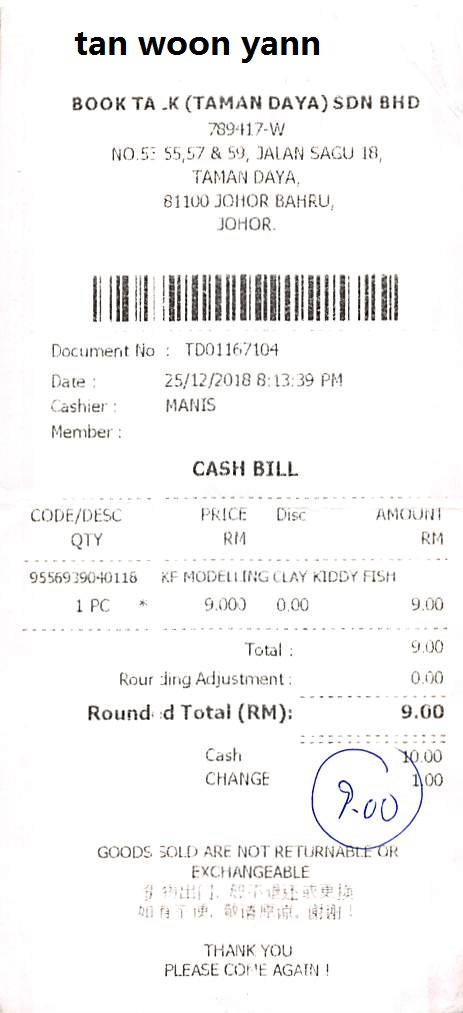

In [ ]:
draw_image(img_fns[0])

We unzip the original files to get the real text of the images (files in boxes folder) and the summary of its text (files in key folder).

In [ ]:
with zipfile.ZipFile(ROOT+DOCS_DATASET_PATH+'.zip', 'r') as external_zip:
  for c in classes:
    with external_zip.open(c+'.zip') as internal_zip:
        with zipfile.ZipFile(internal_zip, 'r') as internal_zip_file:
          internal_zip_file.extractall(ROOT)
          
          if not os.path.exists(ROOT+OCR_DATA_PATH+'/'+ocr_extract[0]):
            os.makedirs(ROOT+OCR_DATA_PATH+'/'+ocr_extract[0])

          if not os.path.exists(ROOT+OCR_DATA_PATH+'/'+ocr_extract[1]):
            os.makedirs(ROOT+OCR_DATA_PATH+'/'+ocr_extract[1])

          filenames = internal_zip_file.namelist()
          for f in filenames:
            if f.endswith('.csv') and f.startswith(c+'/'+ocr_extract[0]):
              shutil.copy(ROOT+f, ROOT+OCR_DATA_PATH+'/'+ocr_extract[0])
            elif f.endswith('.json') and f.startswith(c+'/'+ocr_extract[1]):
              shutil.copy(ROOT+f, ROOT+OCR_DATA_PATH+'/'+ocr_extract[1])

          print(len(os.listdir(ROOT+OCR_DATA_PATH+'/'+ocr_extract[0])))
          print(len(os.listdir(ROOT+OCR_DATA_PATH+'/'+ocr_extract[1])))

626
626


We load the real text of the images.

In [ ]:
def load_real_text(image_id):
  boxFile = ROOT+OCR_DATA_PATH+'/'+ocr_extract[0]+'/'+image_id+'.csv'
  colNames = boxColPos + worldCol

  boxes = pd.read_csv(boxFile, sep=',', header=None, names=colNames)
  return boxes

In [ ]:
id = 0
image_id = img_fns[id].split('/')[-1].split('.')[0]
boxes_image_id = load_real_text(image_id)
boxes_image_id.head()

0    1    2    3    4    5    6    7                          word01  \
0   72   25  326   25  326   64   72   64                   TAN WOON YANN   
1   50   82  440   82  440  121   50  121  BOOK TA .K(TAMAN DAYA) SDN BND   
2  205  121  285  121  285  139  205  139                        789417-W   
3  110  144  383  144  383  163  110  163                        NO.53 55   
4  192  169  299  169  299  187  192  187                      TAMAN DAYA   

    word02          word03  word04  word05  word06  word07  word08  word09  
0      NaN             NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1      NaN             NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2      NaN             NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3  57 & 59   JALAN SAGU 18     NaN     NaN     NaN     NaN     NaN     NaN  
4      NaN             NaN     NaN     NaN     NaN     NaN     NaN     NaN

And transform the dataframe to contain the values in the correct form (bbox representation and text content)

In [ ]:
def transform_boxes_file(boxes):
  bboxNewColumn = []
  textNewColumn = []
  for r in range(len(boxes)):
    bboxNewColumn.append([[boxes.iloc[r]['0'], boxes.iloc[r]['1']], 
                            [boxes.iloc[r]['2'], boxes.iloc[r]['3']],
                            [boxes.iloc[r]['4'], boxes.iloc[r]['5']],
                            [boxes.iloc[r]['6'], boxes.iloc[r]['7']],
                            ])
    
    text = ''
    for w in worldCol:
      if not pd.isnull(boxes.iloc[r][w]):
        if text != '':
          text = text +',' + boxes.iloc[r][w]
        else:
          text = boxes.iloc[r][w]

    textNewColumn.append(text)

  boxes['bbox'] = bboxNewColumn
  boxes['text'] = textNewColumn

  boxes = boxes.drop(boxColPos, axis='columns')
  boxes = boxes.drop(worldCol, axis='columns')
  return boxes

In [ ]:
boxesClean_image_id = transform_boxes_file(boxes_image_id)
boxesClean_image_id.head()

bbox  \
0        [[72, 25], [326, 25], [326, 64], [72, 64]]   
1      [[50, 82], [440, 82], [440, 121], [50, 121]]   
2  [[205, 121], [285, 121], [285, 139], [205, 139]]   
3  [[110, 144], [383, 144], [383, 163], [110, 163]]   
4  [[192, 169], [299, 169], [299, 187], [192, 187]]   

                              text  
0                    TAN WOON YANN  
1   BOOK TA .K(TAMAN DAYA) SDN BND  
2                         789417-W  
3  NO.53 55,57 & 59, JALAN SAGU 18  
4                       TAMAN DAYA

In [ ]:
def get_actual_text_and_boxes(id):
  image_id = img_fns[id].split('/')[-1].split('.')[0]
  boxes_image_id = load_real_text(image_id)
  boxesClean_image_id = transform_boxes_file(boxes_image_id)
  return boxesClean_image_id

### 2. Showing an example of what we have to obtain

In [ ]:
'/content/drive/MyDrive/ColabNotebooks/000copia.jpg'

In [ ]:
img_fns[id]

'/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/train/Tickets/000.jpg'

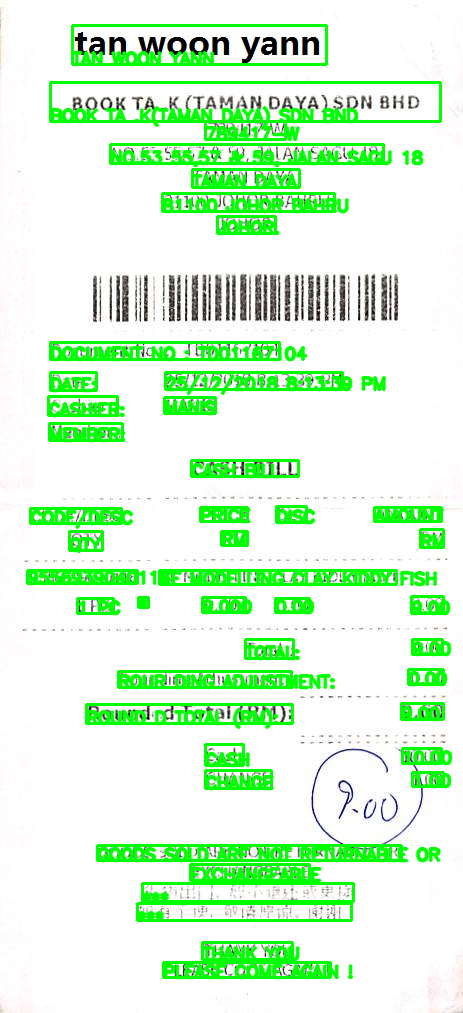

In [ ]:
draw_image(img_fns[id], n_boxes_actual=boxesClean_image_id['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, text_actual=boxesClean_image_id['text'].tolist())

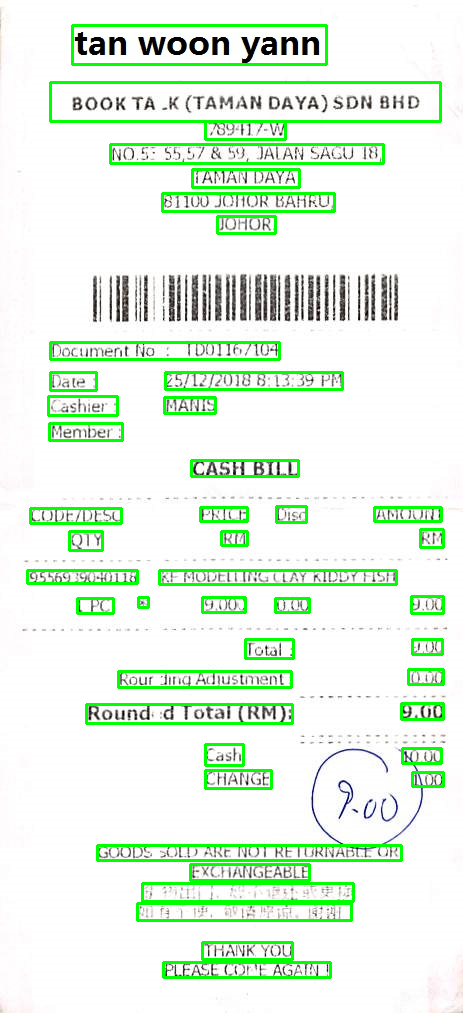

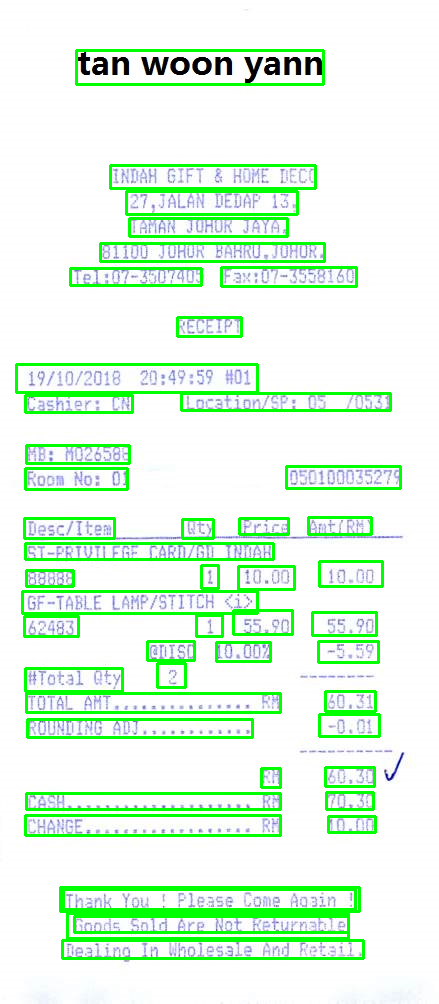

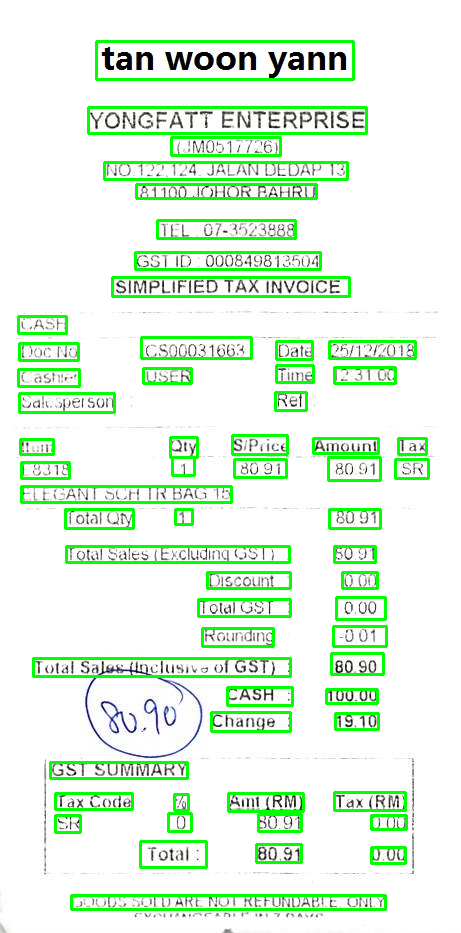

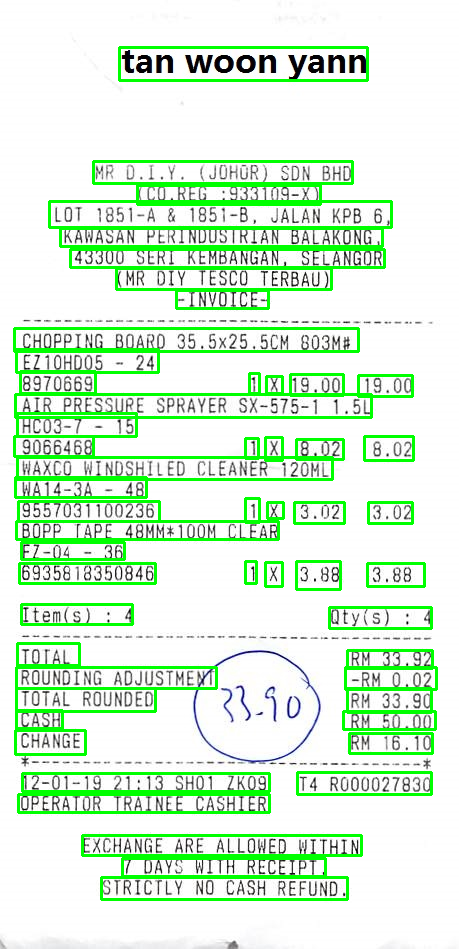

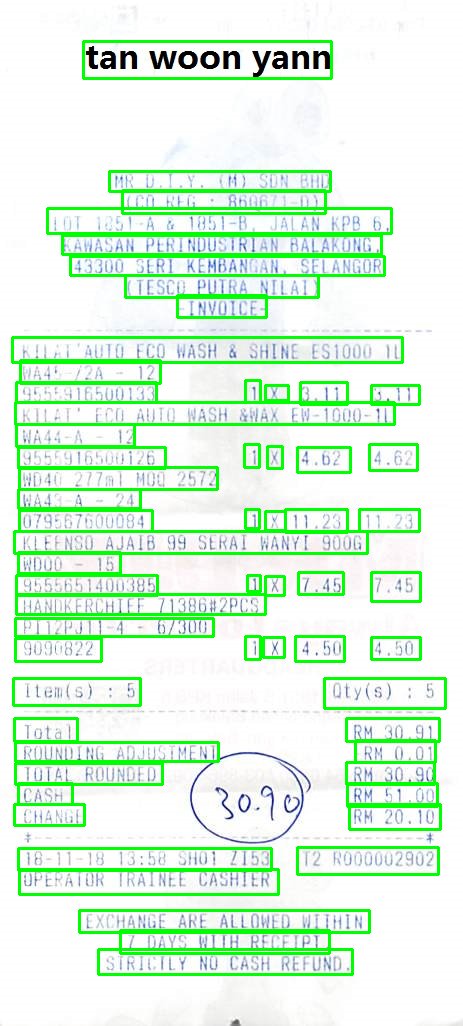

In [ ]:
for id in range(5):
  actual = get_actual_text_and_boxes(id)
  draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2)

### 3. Analizing pytesseract vs easyocr vs Google Cloud Vision API

There are several python libraries that already do an Optical Character Recognition (OCR), so we will try to extract the text of all the Tickets with both of them: pytesseract and easyOCR; to decide the one will be used in this project.

#### 3.1. Method 1: pytesseract

Install package. Detect text in image and get only the references that contains at least one character detected (conf diferent of -1).



In [ ]:
# - Page segmentation modes:
# 0.Orientation and script detection (OSD) only.
# 1.Automatic page segmentation with OSD.
# 2.Automatic page segmentation, but no OSD, or OCR. (not implemented)
# 3.Fully automatic page segmentation, but no OSD. (Default)
# 4.Assume a single column of text of variable sizes.
# 5.Assume a single uniform block of vertically aligned text.
# 6.Assume a single uniform block of text.
# 7.Treat the image as a single text line.
# 8.Treat the image as a single word.
# 9.Treat the image as a single word in a circle.
# 10.Treat the image as a single character.
# 11.Sparse text. Find as much text as possible in no particular order.
# 12.Sparse text with OSD.
# 13.Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

# - OCR Engine modes:
# 0.Legacy engine only.
# 1.Neural nets LSTM engine only.
# 2.Legacy + LSTM engines.
# 3.Default, based on what is available.

In [ ]:
import pytesseract
import time

options = "--psm 4 --oem 3"

In [ ]:
id=0
start = time.time()
image = cv2.imread(img_fns[id])


resTesseract = pytesseract.image_to_data(img_fns[id], lang='eng', output_type='data.frame', config=options)
print(time.time()-start)
resTesseract_text = resTesseract[resTesseract.conf != -1]
resTesseract_text.head()

1.5960285663604736


level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
4       5         1          1        1         1         1    75   32     51   
5       5         1          1        1         1         2   138   37     91   
6       5         1          1        1         1         3   241   37     78   
10      5         1          2        1         1         1    73   97     52   
11      5         1          2        1         1         2   132   97     46   

    height  conf  text  
4       23    93   tan  
5       18    92  woon  
6       26    92  yann  
10      13    93  BOOK  
11      13    50  TA-K

In [ ]:
def transform_bbox_result(df):
  df = df.copy(deep=True)
  bboxNewColumn = []
  for r in range(len(df)):
    top = df.iloc[r]['top']
    left = df.iloc[r]['left']
    height = df.iloc[r]['height']
    width = df.iloc[r]['width']

    tl = [left, top]
    bl = [left, top+height]
    tr = [left+width, top]
    br = [left+width, top+height]
    
    bbox_list = [tl, bl, tr, br]

    bboxNewColumn.append(bbox_list)

  df['bbox'] = bboxNewColumn

  df = df.drop(['top', 'left', 'height', 'width'], axis='columns')

  return df

Transform the reference positions of detected text to get a bbox representation and visualize with the actual text of the image.

In [ ]:
resTesseract_text = transform_bbox_result(resTesseract_text)
resTesseract_text.head()

level  page_num  block_num  par_num  line_num  word_num  conf  text  \
4       5         1          1        1         1         1    93   tan   
5       5         1          1        1         1         2    92  woon   
6       5         1          1        1         1         3    92  yann   
10      5         1          2        1         1         1    93  BOOK   
11      5         1          2        1         1         2    50  TA-K   

                                              bbox  
4       [[75, 32], [75, 55], [126, 32], [126, 55]]  
5     [[138, 37], [138, 55], [229, 37], [229, 55]]  
6     [[241, 37], [241, 63], [319, 37], [319, 63]]  
10    [[73, 97], [73, 110], [125, 97], [125, 110]]  
11  [[132, 97], [132, 110], [178, 97], [178, 110]]

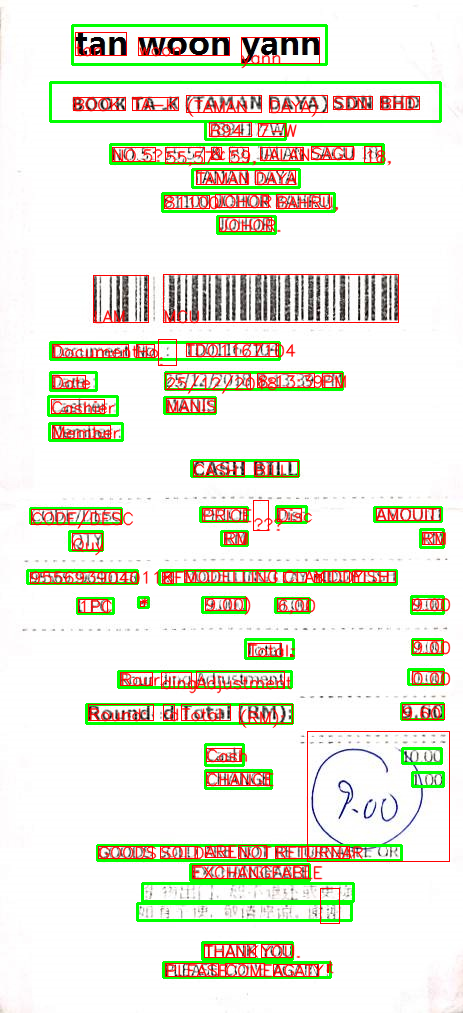

In [ ]:
actual = get_actual_text_and_boxes(0)
draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, 
                        n_boxes_pred=resTesseract_text['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1, text_pred=resTesseract_text['text'].tolist())

Let's try it with different examples (and all of them).

In [ ]:
import time

df_teseract = []

for id in range(10):
#for id in range(len(img_fns)):
  start_time = time.time()
  resTesseract = pytesseract.image_to_data(img_fns[id], lang='eng', output_type='data.frame', config=options)
  resTesseract_text = resTesseract[resTesseract.conf != -1]
  resTesseract_text = transform_bbox_result(resTesseract_text)
  end_time = time.time() - start_time

  df_teseract.append([resTesseract_text['bbox'].tolist(), resTesseract_text['text'].tolist(), resTesseract_text['conf'].tolist(), img_fns[id], end_time])

  #actual = get_actual_text_and_boxes(id)
  #draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, n_boxes_pred=resTesseract_text['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1)

In [ ]:
df_t = pd.DataFrame (df_teseract, columns = ['bbox', 'text', 'confidence', 'img_id', 'time'])
df_t['text']

0      [tan, woon, yann, BOOK, TA-K, (TAMAN, DAYA), S...
1      [tan, woon, yann, INDAH, GIFT, &, HOME, BECO, ...
2      [tan, woon, yann, YONGFATT, ENTERPRISE, (4M051...
3      [tan, woon, yann, MR, O.1.¥., (JOHOR), SDN, BH...
4      [tan, woon, yann, MR, O.T.Y., (M), SON, BHD, (...
                             ...                        
621    [ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...
622    [ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...
623    [4, CNE, ONE, THREE, SEAFOOD, RESTAURANT, SDN,...
624    [3180303, GL, HANDICRAFT, &, TAILORING, 19,, J...
625    [3180303, WAN, HING, STATIONERY, SDN, BHD, (16...
Name: text, Length: 626, dtype: object

#### 3.2. Method 2: easyocr

In [ ]:
import easyocr

reader = easyocr.Reader(['en'], gpu = True)

In [ ]:
id=0
resEasyocr = reader.readtext(img_fns[id])
resEasyocr = pd.DataFrame(resEasyocr, columns=['bbox', 'text', 'confidence'])
resEasyocr.head()

bbox  \
0        [[68, 22], [328, 22], [328, 71], [68, 71]]   
1      [[68, 90], [422, 90], [422, 116], [68, 116]]   
2  [[205, 119], [287, 119], [287, 139], [205, 139]]   
3  [[109, 143], [381, 143], [381, 163], [109, 163]]   
4  [[188, 164], [302, 164], [302, 188], [188, 188]]   

                              text  confidence  
0                    tan woon yann    0.997659  
1  Book TA _k (TAMAN DAYA) SDN BHD    0.468755  
2                         789117-W    0.254535  
3      NO5 55,57 & $ JALAN SAGU In    0.213012  
4                      TAMAN DAYA;    0.813247

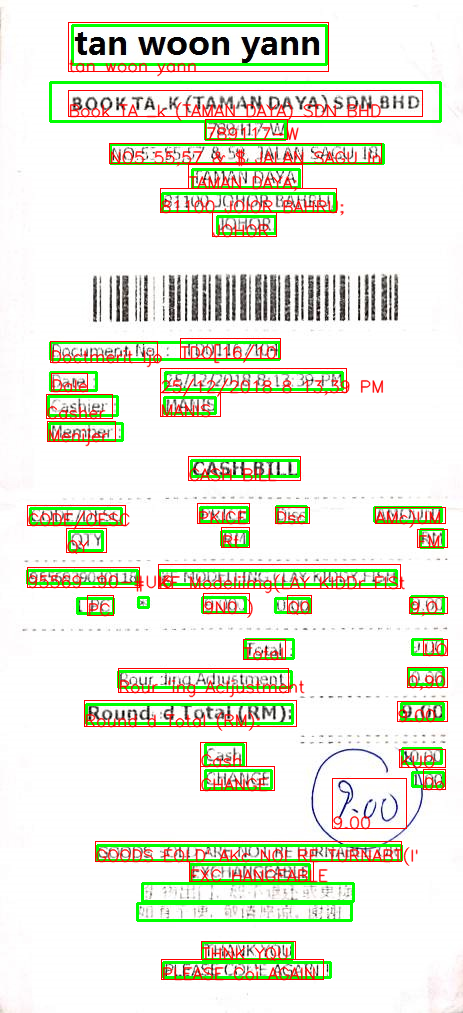

In [ ]:
actual = get_actual_text_and_boxes(0)
draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, 
                        n_boxes_pred=resEasyocr['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1, text_pred=resEasyocr['text'].tolist())

In [ ]:
df_easyocr = []

for id in range(10):
  start_time = time.time()
  resEasyocr = reader.readtext(img_fns[id])
  img_df = pd.DataFrame(resEasyocr, columns=['bbox', 'text', 'confidence'])
  end_time = time.time() - start_time

  df_easyocr.append([img_df['bbox'].tolist(), img_df['text'].tolist(), img_df['confidence'].tolist(), img_fns[id], end_time])

  #actual = get_actual_text_and_boxes(id)
  #draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, n_boxes_pred=img_df['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1)

"df_easyocr = []\n\nfor id in range(10):\n  start_time = time.time()\n  resEasyocr = reader.readtext(img_fns[id])\n  img_df = pd.DataFrame(resEasyocr, columns=['bbox', 'text', 'confidence'])\n  end_time = time.time() - start_time\n\n  df_easyocr.append([img_df['bbox'].tolist(), img_df['text'].tolist(), img_df['confidence'].tolist(), img_fns[id], end_time])\n\n  #actual = get_actual_text_and_boxes(id)\n  #draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, n_boxes_pred=img_df['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1)\n  "

Executing easyOCR with CPU mode (it lasts more than 3 hours to finnish).

In [ ]:
#df_easyocr_without_gpu = []

#for id in range(len(img_fns)):
#  start_time = time.time()
#  resEasyocr = reader.readtext(img_fns[id])
#  img_df = pd.DataFrame(resEasyocr, columns=['bbox', 'text', 'confidence'])
#  end_time = time.time() - start_time

#  df_easyocr_without_gpu.append([img_df['bbox'].tolist(), img_df['text'].tolist(), img_df['confidence'].tolist(), img_fns[id], end_time])

  #actual = get_actual_text_and_boxes(id)
  #draw_image(img_fns[id], n_boxes_actual=actual['bbox'].tolist(), boxcolor_actual=(0,255,0), boxsize_actual=2, n_boxes_pred=img_df['bbox'].tolist(), boxcolor_pred=(0,0,255), boxsize_pred=1)

#### 3.3. Method 3: Google Cloud Vision API

In order to use the API in our code, it forces us to sign up by registering a payment method. So we have tryied the API in its website.

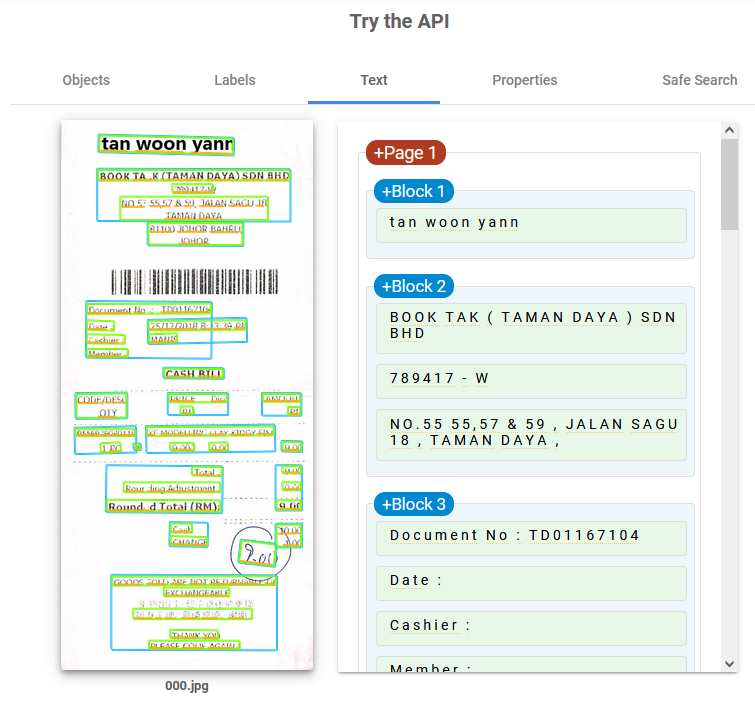

As the results were quite good, we have checked the pricing policies. 
https://cloud.google.com/vision/pricing

Although you can perform 1,000 operations per month for free, each action on an image corresponds to an operation, so to obtain the same results as the other libraries, 2 operations per image should be consumed, which means being able to analyze 500 images a month. In the case study we have more than 600 tickets, so we could not manage to analyze all of them.

So we discart this method.

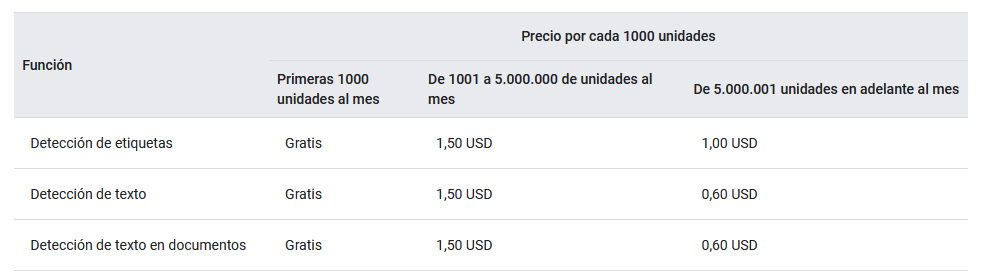


### 4. Benchmarking pytesseract vs easyocr

#### 4.1. Results Tesseact

In [ ]:
df_t = pd.DataFrame (df_teseract, columns = ['bbox', 'text', 'confidence', 'img_id', 'time'])
df_t.head()

bbox  \
0  [[[75, 32], [75, 55], [126, 32], [126, 55]], [...   
1  [[[78, 52], [78, 75], [130, 52], [130, 75]], [...   
2  [[[102, 47], [102, 70], [153, 47], [153, 70]],...   
3  [[[122, 50], [122, 73], [173, 50], [173, 73]],...   
4  [[[85, 46], [85, 69], [137, 46], [137, 69]], [...   

                                                text  \
0  [tan, woon, yann, BOOK, TA-K, (TAMAN, DAYA), S...   
1  [tan, woon, yann, INDAH, GIFT, &, HOME, BECO, ...   
2  [tan, woon, yann, YONGFATT, ENTERPRISE, (4M051...   
3  [tan, woon, yann, MR, O.1.¥., (JOHOR), SDN, BH...   
4  [tan, woon, yann, MR, O.T.Y., (M), SON, BHD, (...   

                                          confidence  \
0  [93, 92, 92, 93, 50, 92, 92, 96, 55, 0, 0, 43,...   
1  [92, 91, 92, 91, 91, 91, 96, 69, 64, 64, 53, 9...   
2  [92, 92, 92, 92, 96, 15, 79, 79, 93, 93, 81, 9...   
3  [93, 91, 92, 55, 15, 89, 96, 84, 85, 39, 92, 8...   
4  [93, 88, 92, 72, 19, 74, 87, 94, 80, 80, 0, 0,...   

                                              img_id      time  
0  /content/drive/MyDrive/ColabNotebooks/Database...  1.619871  
1  /content/drive/MyDrive/ColabNotebooks/Database...  1.851157  
2  /content/drive/MyDrive/ColabNotebooks/Database...  1.799803  
3  /content/drive/MyDrive/ColabNotebooks/Database...  2.532096  
4  /content/drive/MyDrive/ColabNotebooks/Database...  3.406542

In [ ]:
def mean_conf(df_t):
  if len(df_t['confidence'])>0:
    df_t['confidence'] = (sum(df_t['confidence']) / len(df_t['confidence']))
  else:
    df_t['confidence'] = -1
  return df_t

def norm_conf(df_t):
  df_t['confidence'] = df_t['confidence']/100
  return df_t

def count_bbox_items(df_t):
  df_t['bbox'] = len(df_t['bbox'])
  return df_t

def count_num_char(df_t):
  words= df_t['text']
  df_t['num_characters'] = sum(len(str(i)) for i in words)
  return df_t

def count_num_words(df_t):
  words= df_t['text']
  total_w = 0
  for item in words:
    total_w += len(str(item).split())

  df_t['num_words'] = total_w
  return df_t

def img_format_name(df_t):
  df_t['img_id'] = df_t['img_id'].split('/')[-1]
  return df_t

In [ ]:
df_t = df_t.apply(mean_conf, axis=1)
df_t = df_t.apply(norm_conf, axis=1)
df_t = df_t.apply(count_bbox_items, axis=1)
df_t = df_t.apply(count_num_char, axis=1)
df_t = df_t.apply(count_num_words, axis=1)
df_t = df_t.apply(img_format_name, axis=1)
df_t=df_t.drop(['text'], axis='columns')
df_t.head()

bbox                                               text  confidence  \
0    87  [tan, woon, yann, BOOK, TA-K, (TAMAN, DAYA), S...    0.741264   
1    84  [tan, woon, yann, INDAH, GIFT, &, HOME, BECO, ...    0.790119   
2   104  [tan, woon, yann, YONGFATT, ENTERPRISE, (4M051...    0.755000   
3   128  [tan, woon, yann, MR, O.1.¥., (JOHOR), SDN, BH...    0.830781   
4   140  [tan, woon, yann, MR, O.T.Y., (M), SON, BHD, (...    0.689286   

                                              img_id      time  
0  /content/drive/MyDrive/ColabNotebooks/Database...  1.619871  
1  /content/drive/MyDrive/ColabNotebooks/Database...  1.851157  
2  /content/drive/MyDrive/ColabNotebooks/Database...  1.799803  
3  /content/drive/MyDrive/ColabNotebooks/Database...  2.532096  
4  /content/drive/MyDrive/ColabNotebooks/Database...  3.406542

#### 4.2. Results EasyOCR

Applying EasyOCR with GPU mode:



In [ ]:
df_e = pd.DataFrame (df_easyocr, columns = ['bbox', 'text', 'confidence', 'img_id', 'time'])
df_e.head()

bbox  \
0  [[[68, 22], [328, 22], [328, 71], [68, 71]], [...   
1  [[[72, 43], [332, 43], [332, 91], [72, 91]], [...   
2  [[[98, 44], [262, 44], [262, 76], [98, 76]], [...   
3  [[[116, 41], [376, 41], [376, 89], [116, 89]],...   
4  [[[80, 37], [340, 37], [340, 85], [80, 85]], [...   

                                                text  \
0  [tan woon yann, Book TA _k (TAMAN DAYA) SDN BH...   
1  [tan woon yann, INdAh GIFt, & HOME  DECO, 27,J...   
2  [tan woon, yann, YONGFATT ENTERPRISE, Xm051772...   
3  [tan woon yann, MR, 0.I.Y, JohuR) SDN BHD, (CO...   
4  [tan woon yann, Mk, Suw Biid, Co , KHG, 8616, ...   

                                          confidence  \
0  [0.9984235671746878, 0.4810711930399699, 0.264...   
1  [0.9565424561735971, 0.2076327753300609, 0.706...   
2  [0.9993545190077219, 0.9997263550758362, 0.996...   
3  [0.9600181379656687, 0.9887058833275638, 0.567...   
4  [0.9514652613454581, 0.4531759195206455, 0.471...   

                                              img_id      time  
0  /content/drive/MyDrive/ColabNotebooks/Database...  0.566598  
1  /content/drive/MyDrive/ColabNotebooks/Database...  0.499142  
2  /content/drive/MyDrive/ColabNotebooks/Database...  0.591889  
3  /content/drive/MyDrive/ColabNotebooks/Database...  0.658814  
4  /content/drive/MyDrive/ColabNotebooks/Database...  0.834967

In [ ]:
df_e = df_e.apply(mean_conf, axis=1)
df_e = df_e.apply(count_bbox_items, axis=1)
df_e = df_e.apply(count_num_words, axis=1)
df_e = df_e.apply(count_num_char, axis=1)
df_e = df_e.apply(img_format_name, axis=1)
df_e = df_e.drop(['text'], axis='columns')
df_e.head()

bbox  confidence   img_id      time  num_words  num_characters
0    43    0.541958  000.jpg  0.566598         84             411
1    50    0.631434  001.jpg  0.499142         87             504
2    61    0.554351  003.jpg  0.591889         99             495
3    64    0.624026  002.jpg  0.658814        123             645
4    72    0.415243  004.jpg  0.834967        132             646

Applying EasyOCR with CPU mode:

In [ ]:
df_e = pd.DataFrame (df_easyocr_without_gpu, columns = ['bbox', 'text', 'confidence', 'img_id', 'time'])
df_e.head()

bbox  \
0  [[[68, 22], [328, 22], [328, 71], [68, 71]], [...   
1  [[[72, 43], [332, 43], [332, 91], [72, 91]], [...   
2  [[[98, 44], [262, 44], [262, 76], [98, 76]], [...   
3  [[[116, 41], [376, 41], [376, 89], [116, 89]],...   
4  [[[80, 37], [340, 37], [340, 85], [80, 85]], [...   

                                                text  \
0  [tan woon yann, Book TA _k (TAMAN DAYA) SDN BH...   
1  [tan woon yann, INdAh GIFt, & HOME  DECO, 27,J...   
2  [tan woon, yann, YONGFATT ENTERPRISE, Xm051772...   
3  [tan woon yann, MR, 0.I.Y, JohuR) SDN BHD, (CO...   
4  [tan woon yann, Mk, Suw Biid, Co , KHG, 8616, ...   

                                          confidence  \
0  [0.99765924769995, 0.4687550275521481, 0.25453...   
1  [0.9503914869609594, 0.18552077094044384, 0.68...   
2  [0.9992196514047265, 0.999735951423645, 0.9966...   
3  [0.9510436733202429, 0.9900645746873188, 0.585...   
4  [0.9419587336546411, 0.4605761542280974, 0.491...   

                                              img_id       time  
0  /content/drive/MyDrive/ColabNotebooks/Database...  24.816295  
1  /content/drive/MyDrive/ColabNotebooks/Database...   8.057666  
2  /content/drive/MyDrive/ColabNotebooks/Database...   7.344601  
3  /content/drive/MyDrive/ColabNotebooks/Database...   7.582978  
4  /content/drive/MyDrive/ColabNotebooks/Database...   8.903346

In [ ]:
df_e = df_e.apply(mean_conf, axis=1)
df_e = df_e.apply(count_bbox_items, axis=1)
df_e = df_e.apply(count_num_words, axis=1)
df_e = df_e.apply(count_num_char, axis=1)
df_e = df_e.apply(img_format_name, axis=1)
df_e = df_e.drop(['text'], axis='columns')
df_e.head()

bbox  confidence   img_id       time  num_words  num_characters
0    43    0.553828  000.jpg  24.816295         84             412
1    50    0.645440  001.jpg   8.057666         87             504
2    61    0.560497  003.jpg   7.344601        100             494
3    64    0.633347  002.jpg   7.582978        122             644
4    72    0.417759  004.jpg   8.903346        132             645

In [ ]:
cmp2 = df_e[["time",'bbox', 'num_words', 'num_characters', 'confidence']].mean()
cmp2

time               21.129232
bbox               64.531949
num_words         117.827476
num_characters    600.065495
confidence          0.710962
dtype: float64

#### 4.3. Comparative

In [ ]:
cmp = pd.merge(df_t, df_e, on='img_id', suffixes=('_tes', '_easy'))
cmp = cmp[['img_id', 'time_tes', 'time_easy', 'bbox_tes', 'bbox_easy', 'num_words_tes', 'num_words_easy', 'num_characters_tes', 'num_characters_easy', 'confidence_tes', 'confidence_easy']]
cmp.head()

img_id  time_tes  time_easy  bbox_tes  bbox_easy  num_words_tes  \
0  000.jpg  1.619871   0.566598        87         43             84   
1  001.jpg  1.851157   0.499142        84         50             80   
2  003.jpg  1.799803   0.591889       104         61             94   
3  002.jpg  2.532096   0.658814       128         64            119   
4  004.jpg  3.406542   0.834967       140         72            133   

   num_words_easy  num_characters_tes  num_characters_easy  confidence_tes  \
0              84                 389                  411        0.741264   
1              87                 416                  504        0.790119   
2              99                 427                  495        0.755000   
3             123                 612                  645        0.830781   
4             132                 621                  646        0.689286   

   confidence_easy  
0         0.541958  
1         0.631434  
2         0.554351  
3         0.624026  
4         0.415243

In [ ]:
cmp2 = cmp[["time_tes","time_easy", 'bbox_tes', 'bbox_easy', 'num_words_tes', 'num_words_easy', 'num_characters_tes', 'num_characters_easy', 'confidence_tes', 'confidence_easy']].mean()
cmp2

time_tes                 2.237874
time_easy                0.692714
bbox_tes               109.900000
bbox_easy               58.400000
num_words_tes          104.900000
num_words_easy         108.600000
num_characters_tes     517.700000
num_characters_easy    574.400000
confidence_tes           0.766287
confidence_easy          0.640092
dtype: float64

### 5. Tagging the text of the images

Once the text of the images is detected and extracted with the OCR of tesseact, we will need to select the relevant information. For this we need to know which part of the text corresponds to each type of data we want to obtain (company name, address, date and final amount).

To do so, we will use the KNN model created before to predict the company and address data, while we will compute some regular expressions to get the date and total amout.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.neighbors import KNeighborsClassifier

filename = ROOT+'tfidf_vector.pkl'

transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open(filename, "rb")))
tfidf_feature_names = loaded_vec.get_feature_names()
print(tfidf_feature_names)


# load the model from disk
filename = ROOT+'tag_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '0000', '000000', '0000000011000136498', '0000000011000140428', '0000000109000712950', '0000000111000395667', '00000008', '0000000j10000087385', '000000118927', '000000135412', '000000381000', '000000381093', '000000388658', '000000417969', '000000418218', '000000418294', '000000512077', '000000517515', '000000532075', '000000616775', '0000007802317', '000000810692', '000000811101', '000000812627', '000000820868', '000001', '000001010646', '000001011536', '000001018506', '000001020138429', '000001038556', '000001048211', '000001057436', '000001057437', '000001058621', '000001082678', '000001397686', '000001427416', '000001501083', '000001888854', '000002', '000002003191', '000002009131', '000002336695', '000002781709', '000002926759', '000003384541', '000003596418', '0000036581', '000003767016', '000004023432', '000004089728', '000004146858', '000004291008', '000004291022', '000004497295', '000004820628', '000004921851', '000005043675', '000005270385', '000005457342', '00

The total is obtained by searching for the previous words (Total/TTL) plus the end of the invoice and which contains the highest value.

* Final Total
* TOTAL
* Grand Total
* Total Amount Payable
* Neet Total
* Total After Adj Incl gst
* Total Amount
* Total Sales (Inclusive of GST)
* Total Sales (Inclusive GST)
* Total Due (GST Inc)
* TTL Cash
* Total Rounded
* Ttl Atr rnd
* Total Gross
* Total Incl. GST
* Total incl. gst
* Net Total Rounded (MYR)
* Accepted total

In [ ]:
import re

def find_total(text):
  pricePattern = r'\b(?:TOTAL|TTL)\b'

  p = []
  pos=[]
  i=0
  for row in text.split("\n"):

    if re.search(pricePattern, row) is not None:
      p.append(row)
      pos.append(i)
    i+=1

  price_pat = re.compile(r'\d+\.\d{2}|\d+\,\s?\d{2}')
  price_saved = []
  j=0

  for price in p:
    match = price_pat.search(price)
    if match:
        sa = (match.group()).replace(",", ".")
        sa = sa.replace(" ", "")
        price_saved.append((sa, pos[j]))
    j+=1

  #amounts = re.findall(r'\d+\.\d{2}\b | \d+\,\s?\d{2}\b', p)
  #amounts = [x.replace(",", ".") for x in amounts]
  #amounts = [x.replace(" ", "") for x in amounts]

  if len(price_saved)>0:
    return (price_saved[len(price_saved)-1][0],price_saved[len(price_saved)-1][1])
  else:
    return ('',-1)

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

def find_addr_comp(text):

  values = [('',-1), ('',-1)]

  vec_tess = loaded_vec.transform(text['text'])

  if len(text['text']) == 0:
    return values

  Y_pred = loaded_model.predict(vec_tess)
  text['Y_tag'] = Y_pred
  
  tags_to_search = ['address', 'company']
  t_to_find = text.groupby((text['Y_tag'].shift() != text['Y_tag']).cumsum())
  i = 0
  for t in tags_to_search:
    #print('------------', t, '----------')

    max_group=pd.DataFrame()
    for k, v in t_to_find:
      
      tag_values = v['Y_tag'].tolist()
      tag_list = list(set(tag_values))
      if len(tag_list) == 1 and tag_list[0] == t:

        if len(v) > len(max_group):
          max_group = v
      #print('[group ', k, ']: ', tag_list[0], 'len(v)', len(v), 'len(max_group)', len(max_group))
      #print(max_group)
      #print()
    
    #print(max_group)
    
    if (len(max_group)) > 0:
      values[i] = ((' '.join(max_group['text'].tolist())), Average(max_group['conf'].tolist()), max_group['bbox'].tolist())
      
    else:
      values[i] = ('', -1)

    i+=1

  return values

In [ ]:
!pip install Matcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for Matcher: filename=matcher-0.2-py3-none-any.whl size=3116 sha256=ed540759335fe320e40264153e774dac9b7f04d790b30ff5babbbf65af909997
  Stored in directory: /root/.cache/pip/wheels/0d/90/91/4a6bdebf4456209ad7722c4d8a8bfd5ab7154708232b53bb3c
Successfully built Matcher


In [ ]:
re.search(r'(\d{1,2})?[\s-]?(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-zA-Z.,-]*[\s]? \d{4}', '17 JUN 2018', re.M|re.I)

<re.Match object; span=(0, 11), match='17 JUN 2018'>

In [ ]:
re.search(r'(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-zA-Z.,-]*[\s-]? (\d{1,2})?[,\s-][\s]? \d{4}', 'JUN 17, 2018', re.M|re.I)

<re.Match object; span=(0, 12), match='JUN 17, 2018'>

In [ ]:
def find_date(text):
  datePattern1 = r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}'
  datePattern2 = r'(\d{1,2})?[\s-]?(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-zA-Z.,-]*[\s]? \d{4}'
  datePattern3 = r'\d{1,2}[/-]\d{2,4}'

  p = str()
  pos=[]
  i=0

  #print(text)
  #print('--- FIRST for ---')
  for row in text.split("\n"):
    #print(i,': ', row)
    if re.search(datePattern1, row) is not None:
      p += ' ' + row
      pos.append(i)
      #print(i, ': ', p)
    i += 1
  dates = re.findall(datePattern1, p)
  #print('dates: ', dates)
  #print('pos: ', pos)
  
  if len(dates)>0:
    return (dates[0],pos[0])

  else:
    p = []
    pos=[]
    i=0
    #print('--- SECOND for ---')  
    for row in text.split("\n"):
      #print(i, ': ', row) 
      if re.search(datePattern2, row, re.M|re.I) is not None:
        p.append(row)
        pos.append(i)
        #print(i, ': ', p)
      i+=1
    
    re_dates_with_monthname = re.compile(datePattern2)
    i=0
    for date in p:
      match = re_dates_with_monthname.search(date)
      if match:
        return (match.group(), pos[i])
      i+=1
    

    p = []
    pos=[]
    i=0
    #print('--- THIRD for ---')
    for row in text.split("\n"): 
      #print(i, ': ', row) 
      if re.search(datePattern3, row, re.M|re.I) is not None:
        p.append(row)
        pos.append(i)
        #print(i, ': ', p)
      i+=1
    
    re_dates_with_monthname = re.compile(datePattern3)
    i=0
    for date in p:
      match = re_dates_with_monthname.search(date)
      #print('row', row)
      #print('match', match)
      if match:
        return (match.group(), pos[i])
      i+=1
    
  return ('',-1)

In [ ]:
def summarize_ticket(text):
  infTicket = {'company': ('', -1, ''),
             'date': ('', -1, ''),
             'address': ('', -1, ''),
             'total': ('', -1, '')}

  t_total = ('\n').join(text['text'].tolist())
  t_total = t_total.upper()
  total_values = find_total(t_total)
  if total_values[1]!=-1:
    infTicket['total']= (total_values[0], text.iloc[total_values[1]]['conf'], [text.iloc[total_values[1]]['bbox']])

  date_values = find_date(t_total)

  if date_values[1]!=-1:
    infTicket['date']= (date_values[0], text.iloc[date_values[1]]['conf'], [text.iloc[date_values[1]]['bbox']])

  t_address, t_company = find_addr_comp(text)
  infTicket['address'] = t_address
  infTicket['company'] = t_company
  
  return infTicket

In [ ]:
def join_bbox_result(df):
  df = df.copy(deep=True)
  bboxNewColumn = []
  for r in range(len(df)):
    top = df.iloc[r]['top']
    left = df.iloc[r]['left']
    height = df.iloc[r]['height']
    width = df.iloc[r]['width']
    
    bbox_list = [top, left, height, width]

    bboxNewColumn.append(bbox_list)

  df['bbox'] = bboxNewColumn

  df = df.drop(['top', 'left', 'height', 'width'], axis='columns')

  return df

In [ ]:
#id=470
#print(img_fns[id])
#resTesseract = pytesseract.image_to_data(img_fns[id], lang='eng', output_type='data.frame', config=options)
#resTesseract_text = resTesseract[resTesseract.conf != -1]
#resTesseract_text = transform_bbox_result(resTesseract_text)
#tesseract_lines = resTesseract_text.groupby(by=['page_num', 'block_num', 'par_num', 'line_num'], as_index = False).agg({ 'text': lambda x: ' '.join(list(x)), 'conf': 'mean', 'bbox':lambda x: x.apply(list)})
#tesseract_lines.head()

In [ ]:
id=524
print(img_fns[id])
resTesseract = pytesseract.image_to_data(img_fns[id], lang='eng', output_type='data.frame', config=options)
resTesseract_text = resTesseract[resTesseract.conf != -1]
resTesseract_text = join_bbox_result(resTesseract_text)
tesseract_lines = resTesseract_text.groupby(by=['page_num', 'block_num', 'par_num', 'line_num'], as_index = False).agg({ 'text': lambda x: ' '.join(list(x)), 'conf': 'mean', 'bbox':lambda x: x.apply(list)})
tesseract_lines.head()

/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/524.jpg


page_num  block_num  par_num  line_num  \
0         1          1        1         1   
1         1          2        1         1   
2         1          2        1         2   
3         1          2        1         3   
4         1          2        1         4   

                                               text  conf  \
0                                             dbo 2  48.5   
1             MOONLIGHT CAKE HOUSE SDN BHD 80ZTZ9-U  72.0   
2                        (GST Reg No: 001559298048)  94.0   
3  No.1, Jalan Permas 10/5, Bandar Baru Permas Jaya  93.5   
4    81750 Johor Bahru, Johor. Tel No.: 07-387 3322  94.5   

                                                bbox  
0      [[759, 2700, 140, 263], [811, 2992, 119, 95]]  
1  [[991, 1776, 43, 313], [992, 2128, 40, 135], [...  
2  [[1052, 1975, 74, 130], [1059, 2145, 67, 100],...  
3  [[1147, 1567, 70, 159], [1140, 1775, 68, 171],...  
4  [[1235, 1634, 63, 171], [1227, 1845, 69, 170],...

In [ ]:
rellevant_info = summarize_ticket(tesseract_lines)
rellevant_info

PRICE search
p ['TOTAL (INCL GST, 0X) RM15.39']
p ['TOTAL (INCL GST, 0X) RM15.39', 'TOTAL PAID RM50 .00']
p ['TOTAL (INCL GST, 0X) RM15.39', 'TOTAL PAID RM50 .00']
TOTAL (INCL GST, 0X) RM15.39
<re.Match object; span=(23, 28), match='15.39'>
TOTAL PAID RM50 .00
None
amounts [('15.39', 26)]
--- FIRST for ---
7 :   09/06/2018 18:47:30
10 :   09/06/2018 18:47:30 INVOICE NO: $P-NUL1-18/06/09-1013481
11 :   09/06/2018 18:47:30 INVOICE NO: $P-NUL1-18/06/09-1013481 DATE + 09/06/2018 18:47:29
dates:  ['09/06/2018', '1-18/06', '09/06/2018']
pos:  [7, 10, 11]


{'company': ('MOONLIGHT CAKE HOUSE SDN BHD 80ZTZ9-U',
  72.0,
  [array([list([991, 1776, 43, 313]), list([992, 2128, 40, 135]),
          list([990, 2303, 42, 171]), list([990, 2514, 40, 102]),
          list([989, 2655, 41, 101]), list([988, 2796, 41, 277])],
         dtype=object)]),
 'date': ('09/06/2018',
  95.5,
  [array([list([4837, 1542, 77, 345]), list([4843, 1934, 64, 269])],
         dtype=object)]),
 'address': ('No.1, Jalan Permas 10/5, Bandar Baru Permas Jaya 81750 Johor Bahru, Johor. Tel No.: 07-387 3322',
  94.0,
  [array([list([1147, 1567, 70, 159]), list([1140, 1775, 68, 171]),
          list([1145, 1986, 61, 205]), list([1139, 2238, 75, 155]),
          list([1139, 2443, 66, 205]), list([1142, 2689, 61, 136]),
          list([1142, 2865, 62, 206]), list([1142, 3113, 69, 133])],
         dtype=object),
   array([list([1235, 1634, 63, 171]), list([1227, 1845, 69, 170]),
          list([1229, 2057, 73, 195]), list([1226, 2301, 69, 197]),
          list([1224, 2549, 71, 9

In [ ]:
def draw_image_highlighted(image_path,n_boxes_pred=[], boxcolor_pred=(0, 0, 255), boxsize_pred=1):
    img = cv2.imread(image_path)

    #colors = [(159, 44, 114), (14, 79, 100), (94, 24, 22),  (69, 74, 178)] (0, 95, 26)
    colors = [(54, 105, 139), (13, 170, 0), (139, 72, 26), (0, 0, 139)]
    # Initialize black image of same dimensions for drawing the rectangles
    blk = np.zeros(img.shape, np.uint8)

    if len(n_boxes_pred) > 1 :
      if len(n_boxes_pred) > 1:
        c = 0
        for boxes_rellevant_word in n_boxes_pred:
          iter=0
          for boxes in boxes_rellevant_word:
            print(boxes)
            print(len(boxes))
            print(type(boxes))
            if type(boxes) != list:
              for b in boxes:
                #bbox = BoundingBox(b)

                top_left = (int(b[1]), int(b[0]+b[2]))
                bottom_right = (int(b[1]+b[3]), int(b[0]))

                cv2.rectangle(blk, top_left, bottom_right, colors[c], boxsize_pred)
                out = cv2.addWeighted(img, 1.0, blk, 0.8, 1)
                iter+=1
            else:
              top_left = (int(b[1]), int(b[0]+b[2]))
              bottom_right = (int(b[1]+b[3]), int(b[0]))

              cv2.rectangle(blk, top_left, bottom_right, colors[c], boxsize_pred)
              out = cv2.addWeighted(img, 1.0, blk, 0.8, 1)
              iter+=1
          c+=1

              
      else:
        i = n_boxes_pred
        bbox = BoundingBox(i)
        top_left = (int(bbox.min_point[0]), int(bbox.max_point[1]))
        bottom_right = (int(bbox.max_point[0]), int(bbox.min_point[1]))
        cv2.rectangle(img, top_left, bottom_right, boxcolor_pred, boxsize_pred)

    cv2_imshow(out)

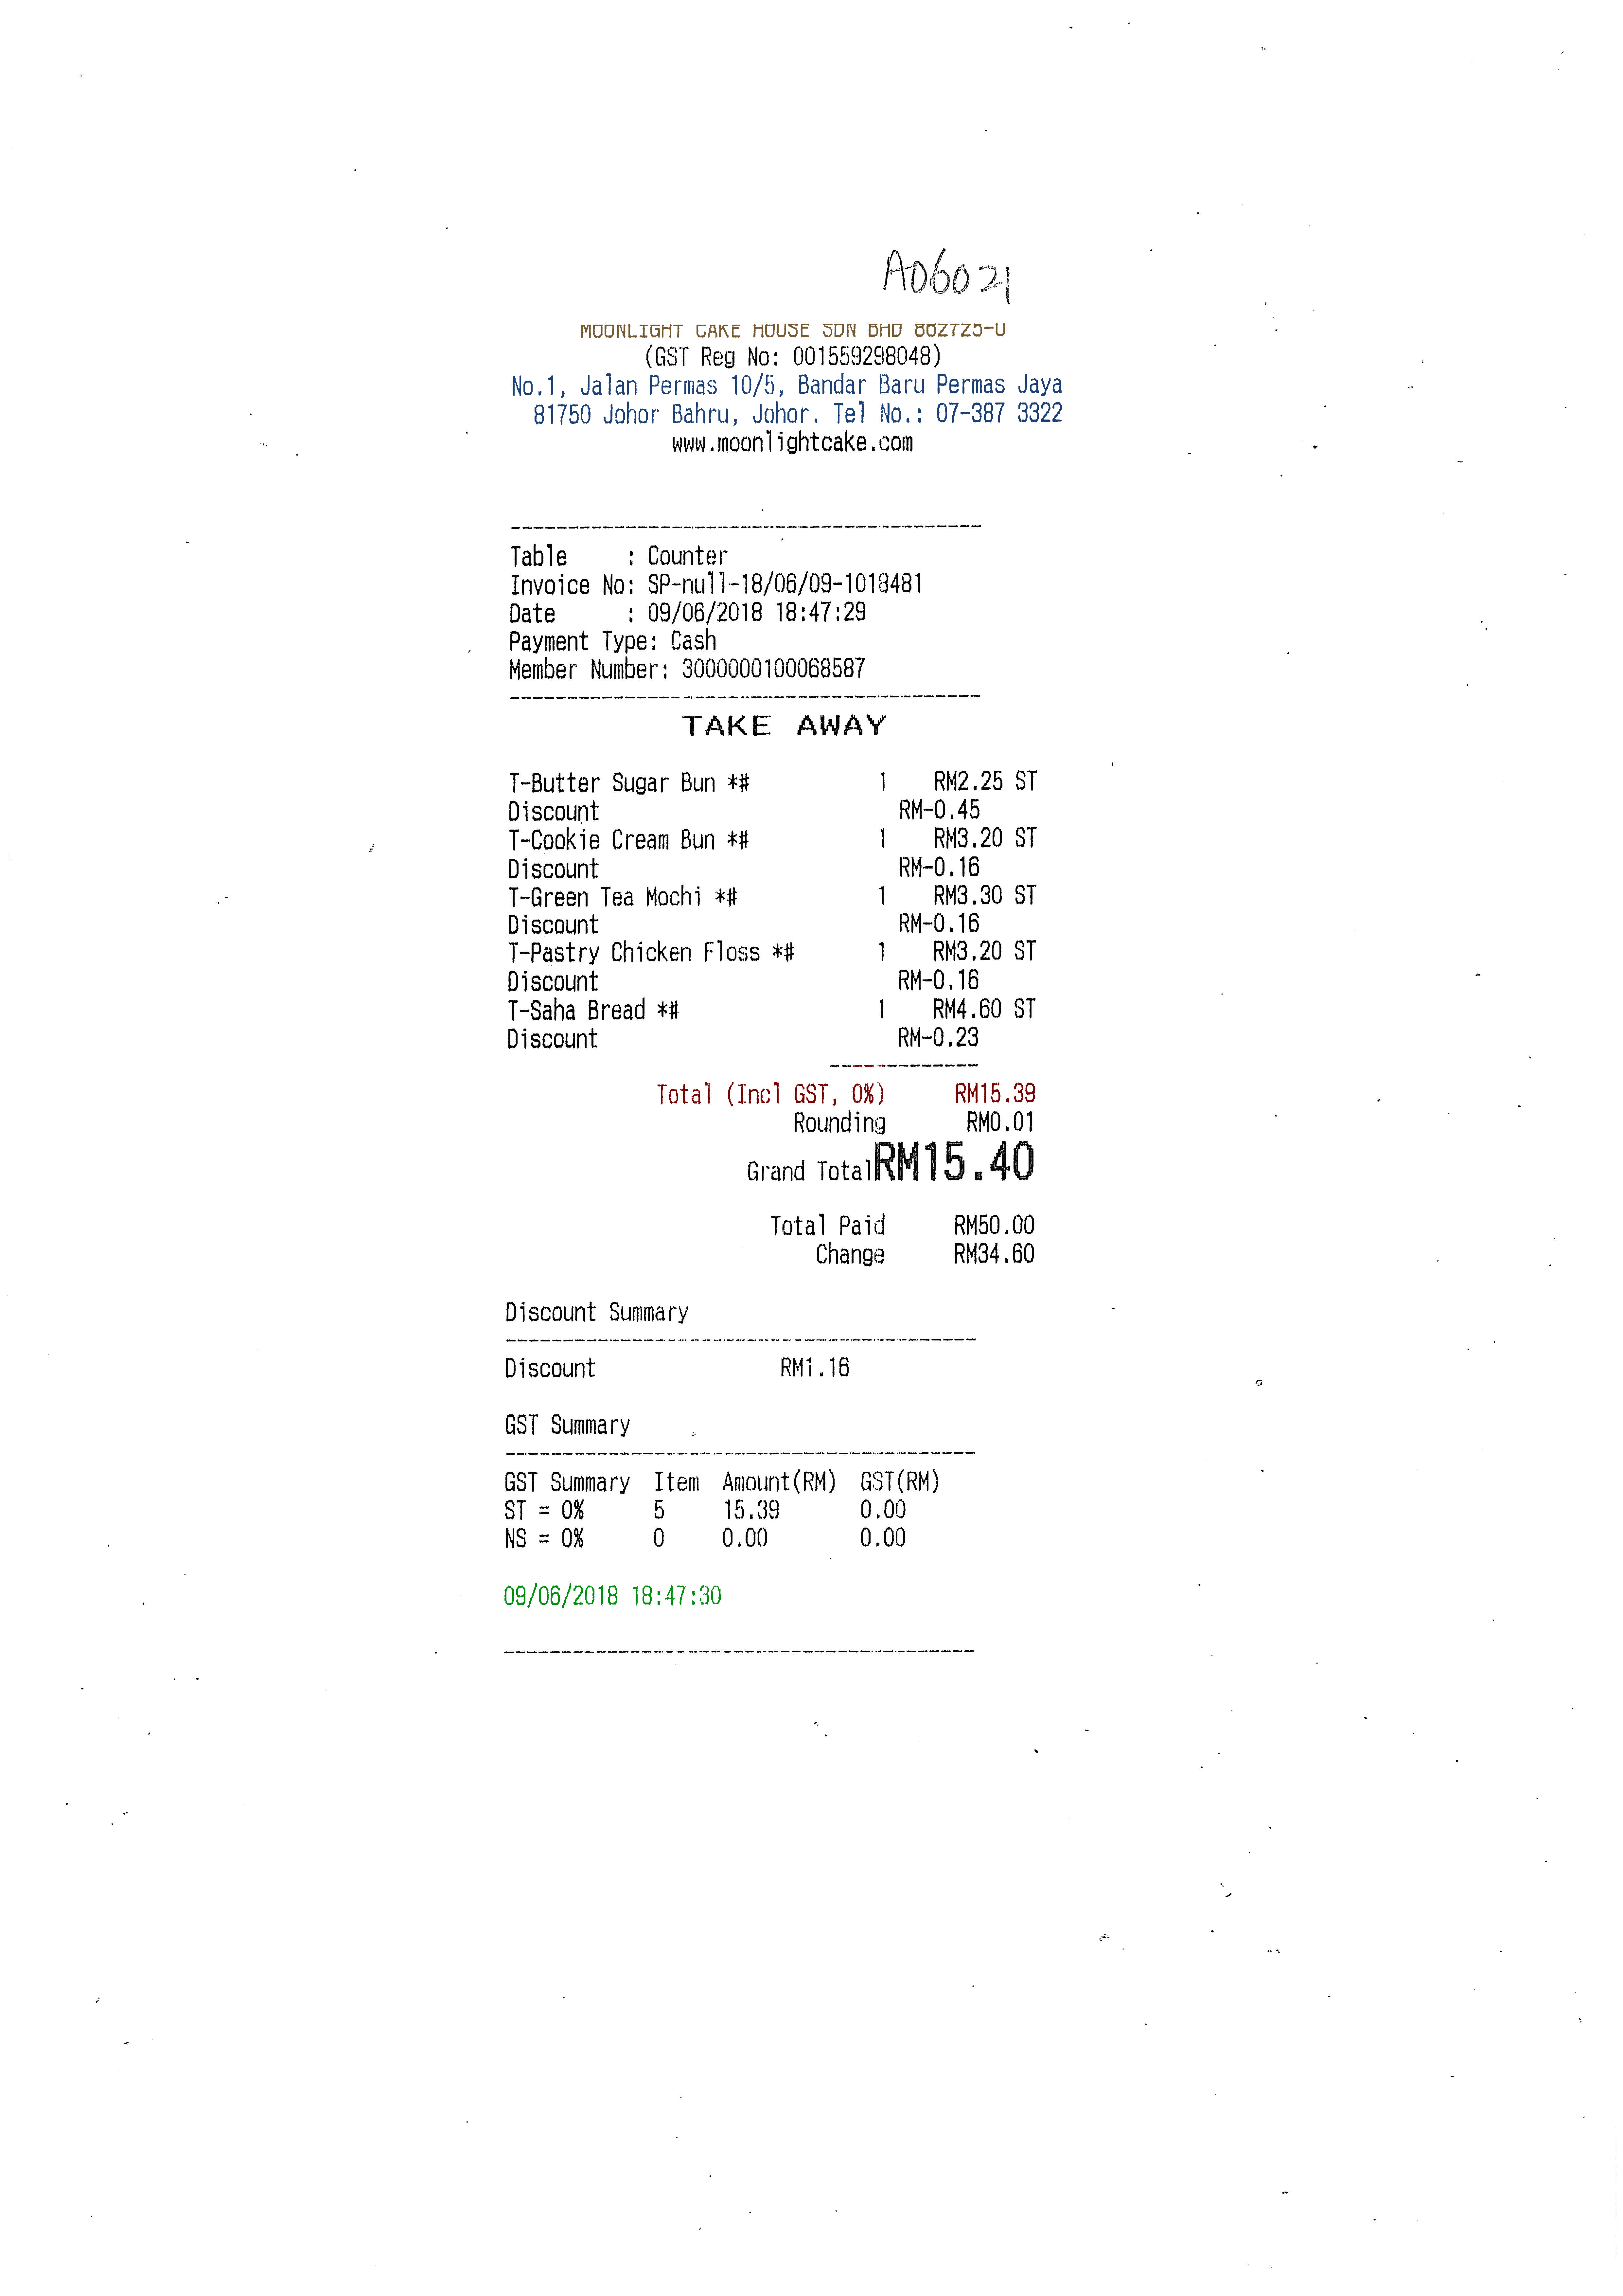

In [ ]:
bboxes_to_draw = []
for i in rellevant_info.keys():
  bboxes_to_draw.append(rellevant_info[i][2])
  
draw_image_highlighted(img_fns[id], n_boxes_pred=bboxes_to_draw, boxcolor_pred=(0,0,255), boxsize_pred=-1)

### 6. Calculating metrics

https://github.com/kennethleungty/OCR-Metrics-CER-WER/blob/main/OCR_Metrics_CER_WER_Colab.ipynb

Character Error Rate (CER). Is based on the concept of Levenshtein distance, where we count the minimum number of character-level operations required to transform the ground truth text (aka reference text) into the OCR output.

The main function  `calculate_cer` expect tokenized input.



In [ ]:
!pip install cer
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: levenshtein
    Found existing installation: Levenshtein 0.20.9
    Uninstalling Levenshtein-0.20.9:
      Successfully uninstalled Levenshtein-0.20.9


In [ ]:
import json

def get_actual_key_values(image_id):
  image_id = img_fns[image_id].split('/')[-1].split('.')[0]
  keyFile = ROOT+OCR_DATA_PATH+'/'+ocr_extract[1]+'/'+image_id+'.json'
  f = open(keyFile)
  jskey = json.load(f)
  f.close()
  return jskey

In [ ]:
act_Key = get_actual_key_values(id)

In [ ]:
from cer import calculate_cer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from jiwer import wer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
import time

df_metrics = []

for id in range(len(img_fns)):
    resTesseract = pytesseract.image_to_data(img_fns[id], lang='eng', output_type='data.frame', config=options)
    resTesseract_text = resTesseract[resTesseract.conf != -1]
    resTesseract_text = join_bbox_result(resTesseract_text)
    resTesseract_text['text'] = resTesseract_text['text'].apply(str)
    tesseract_lines = resTesseract_text.groupby(by=['page_num', 'block_num', 'par_num', 'line_num'], as_index = False).agg({ 'text': lambda x: ' '.join(list(x)), 'conf': 'mean', 'bbox':lambda x: x.apply(list)})
    rellevant_info = summarize_ticket(tesseract_lines)

    act_Key = get_actual_key_values(id)
    for t in taggs:
      if (rellevant_info[t][0])!='' and act_Key[t]!='':
        cer_score = calculate_cer(word_tokenize(act_Key[t]), word_tokenize(rellevant_info[t][0]))
        wer_score = wer(act_Key[t], rellevant_info[t][0])
        conf = rellevant_info[t][1]
      else:
        cer_score = 1.0
        wer_score = 1.0
        conf = 0.0
      df_metrics.append([t, cer_score, wer_score, conf])

 
print('DONE')

DONE


In [ ]:
df_m = pd.DataFrame (df_metrics, columns = ['tag', 'cer', 'wer', 'conf'])
df_m.head()

tag       cer       wer       conf
0     date  0.000000  0.000000  81.750000
1    total  0.000000  0.000000  75.333333
2  company  0.060606  0.285714  79.666667
3  address  0.080000  0.153846  82.541667
4     date  0.000000  0.000000  78.666667

In [ ]:
for t in taggs:
  df_m.loc[df_m['tag']==t]
  print(t)
  print(df_m.loc[df_m['tag']==t].head())
  print('\ncer', df_m.loc[df_m['tag']==t]['cer'].mean())
  print('wer', df_m.loc[df_m['tag']==t]['wer'].mean())
  print('conf', df_m.loc[df_m['tag']==t]['conf'].mean())
  print('\n-------\n')

date
     tag  cer  wer       conf
0   date  0.0  0.0  81.750000
4   date  0.0  0.0  78.666667
8   date  0.1  1.0  67.666667
12  date  0.5  1.0  38.875000
16  date  0.0  0.0  56.500000

cer 0.20363510734916485
wer 0.3391906283280085
conf 68.97258862011257

-------

total
      tag  cer  wer       conf
1   total  0.0  0.0  75.333333
5   total  1.0  1.0   0.000000
9   total  0.2  1.0  62.500000
13  total  0.0  0.0  90.500000
17  total  0.0  0.0  81.000000

cer 0.3931823368324966
wer 0.6038338658146964
conf 63.58838810284497

-------

company
        tag       cer       wer       conf
2   company  0.060606  0.285714  79.666667
6   company  0.045455  0.200000  87.600000
10  company  0.000000  0.000000  94.000000
14  company  0.107143  0.200000  67.800000
18  company  0.125000  0.400000  69.200000

cer 0.40664962012968275
wer 0.505464273036158
conf 69.94375538820427

-------

address
        tag       cer       wer       conf
3   address  0.080000  0.153846  82.541667
7   address  0.338235 

Word Error Rate (WER). [Word Error Rate](https://pypi.org/project/cer/1.0.1/) might be more applicable if it involves the transcription of paragraphs and sentences of words with meaning (e.g., pages of books, newspapers).

The formula for WER is the same as that of CER, but WER operates at the word level instead. It represents the number of word substitutions, deletions, or insertions needed to transform one sentence into another.

the absolute WER value is expected to be higher than the CER value.

### 7. Spelling checker

In [ ]:
act = get_actual_text_and_boxes(id)['text']

In [ ]:
doc.ents

(YANN BOOK TA .K(TAMAN,
 JALAN,
 25/12/2018,
 8:13:39 PM CASHIER,
 9556939040116,
 1,
 9.000,
 0.00,
 9.00,
 10.00,
 1.00,
 9.00)

In [ ]:
(' '.join(act.tolist()))

'TAN WOON YANN BOOK TA .K(TAMAN DAYA) SDN BND 789417-W NO.53 55,57 & 59, JALAN SAGU 18 TAMAN DAYA 81100 JOHOR BAHRU JOHOR. DOCUMENT NO : TD01167104 DATE: 25/12/2018 8:13:39 PM CASHIER: MANIS MEMBER: CASH BILL CODE/DESC PRICE DISC AMOUNT QTY RM RM 9556939040116 KF MODELLING CLAY KIDDY FISH 1 PC * 9.000 0.00 9.00 TOTAL: ROUR DING ADJUSTMENT: 0.00 ROUND D TOTAL (RM): 9.00 CASH 10.00 CHANGE 1.00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE *** *** THANK YOU PLEASE COME AGAIN ! 9.00'

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp((' '.join(act.tolist())))

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

YANN BOOK TA .K(TAMAN 9 30 WORK_OF_ART
JALAN 72 77 NORP
25/12/2018 153 163 DATE
8:13:39 PM CASHIER 164 182 TIME
9556939040116 246 259 DATE
1 289 290 CARDINAL
9.000 296 301 CARDINAL
0.00 341 345 CARDINAL
9.00 366 370 CARDINAL
10.00 376 381 CARDINAL
1.00 389 393 CARDINAL
9.00 478 482 CARDINAL


In [ ]:
import re

text = 'he PRN and CC bill NP could MOD hear VB them PRN on IN the DT large JJ balcony NN near IN the DT house NN'

regex = re.compile(r'(?:(?:\w+ DT )?(?:\w+ JJ )*)?\w+ (?:N[NP]|PRN)')
m = regex.findall(text)
print(m)

['he PRN', 'bill NP', 'them PRN', 'the DT large JJ balcony NN', 'the DT house NN']


In [ ]:
t_t = (' '.join(resTesseract_text['text'].tolist()))
t_e = (' '.join(resEasyocr['text'].tolist()))
t_act = (' '.join(act.tolist()))

print(t_act)
print(t_t)
print(t_e)

TAN WOON YANN BOOK TA .K(TAMAN DAYA) SDN BND 789417-W NO.53 55,57 & 59, JALAN SAGU 18 TAMAN DAYA 81100 JOHOR BAHRU JOHOR. DOCUMENT NO : TD01167104 DATE: 25/12/2018 8:13:39 PM CASHIER: MANIS MEMBER: CASH BILL CODE/DESC PRICE DISC AMOUNT QTY RM RM 9556939040116 KF MODELLING CLAY KIDDY FISH 1 PC * 9.000 0.00 9.00 TOTAL: ROUR DING ADJUSTMENT: 0.00 ROUND D TOTAL (RM): 9.00 CASH 10.00 CHANGE 1.00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE *** *** THANK YOU PLEASE COME AGAIN ! 9.00
tan woon yann BOOK TA-K (TAMAN DAYA) SDN BHD B94 7-W NO.5? 55,57 & 59, JALAN SAGU 18, TAMAN DAYA 81100 JOHOR BAHRU, JOHOR. LAM MCU Document Ho : TDO1167104   Date 25/12/2018 8:13:39 PM Cashier MANIS Member CASH BILL CODE/DESC PRICE — Disc AMOUIT Quy RM RM 9556939040118 KF MODELLING CLAY KIDDY FISH 1PC * 9.00) 6,00 9.00 Total : 9.00 Rour ding Adjustment 0.00 Round: :d Total (RM): 9.60 Cash CHANGE    GOODS SOLD ARE NOT RETURNAR EXCHANGEABLE   THANK YOU. PLEASE COME AGATY t
tan woon yann Book TA _k (TAMAN DAYA) SDN

In [ ]:
import re

pattern = r'\d{2}.\d{2}.\d{4}'
print('t_act')
print("\n".join(re.findall(pattern,t_act)), '\n')

print('t_t')
print("\n".join(re.findall(pattern,t_t)), '\n')

print('t_e')
print("\n".join(re.findall(pattern,t_e)), '\n')

t_act
25/12/2018
9556939040 

t_t
25/12/2018
9556939040 

t_e
25/12/2018 



In [ ]:
!pip install TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob


Spelling Correction 
([TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#spelling-correction))

Use the correct() method to attempt spelling correction.

```
b = TextBlob("I havv goood speling!")
print(b.correct())
I have good spelling!
```

Word objects have a spellcheck() Word.spellcheck() method that returns a list of (word, confidence) tuples with spelling suggestions.
```
from textblob import Word
w = Word('falibility')
w.spellcheck()
```
```
[('fallibility', 1.0)]
```

Spelling correction is based on Peter Norvig’s “How to Write a Spelling Corrector”[1] as implemented in the pattern library. It is about 70% accurate [2].


Tokenization
([TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#tokenization))

You can break TextBlobs into words or sentences.
```
zen = TextBlob("Beautiful is better than ugly. "
                "Explicit is better than implicit. "
                "Simple is better than complex.")
zen.words
WordList(['Beautiful', 'is', 'better', 'than', 'ugly', 'Explicit', 'is', 'better', 'than', 'implicit', 'Simple', 'is', 'better', 'than', 'complex'])
zen.sentences
[Sentence("Beautiful is better than ugly."), Sentence("Explicit is better than implicit."), Sentence("Simple is better than complex.")]

```

Spacy
https://spacy.io/usage/linguistic-features#named-entities

Per etiquetar (tagging) paraules en un text i identificar paraules clau.
